<a href="https://colab.research.google.com/github/sadrireza/Neural-Networks/blob/main/Shap_Integrated_OCCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.8 MB/s eta 0:00:00


In [10]:
import numpy as np
import shap
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

In [24]:
# Load your datasets
feature_train = np.load('/mnt/data/FEATURE_TRAINING_COMP.npy')
feature_test = np.load('/mnt/data/FEATURE_TEST_COMP.npy')

# Assuming ANOMALY_Z.npy is your target variable
anomaly_z = np.load('/mnt/data/ANOMALY_Z.npy')

# Use a subset of the data to speed up the process
subset_size = 500  # Adjust this number to control the subset size
feature_train_subset = feature_train[:subset_size]
feature_test_subset = feature_test[:subset_size]
anomaly_z_subset = anomaly_z[:subset_size]

# Define your OCCNN model
def create_occ_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    return model

# Create the model
input_shape = (feature_train_subset.shape[1], 1)
model = create_occ_model(input_shape)

# Reshape the data for the model
feature_train_reshaped = feature_train_subset.reshape((feature_train_subset.shape[0], feature_train_subset.shape[1], 1))
feature_test_reshaped = feature_test_subset.reshape((feature_test_subset.shape[0], feature_test_subset.shape[1], 1))

In [25]:
# Train the model
model.fit(feature_train_reshaped, anomaly_z_subset, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
13/13 [==============================] - 1s 24ms/step - loss: 0.5636 - val_loss: 0.5344
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 0.4987 - val_loss: 0.4552
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 0.4162 - val_loss: 0.3717
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3551 - val_loss: 0.3342
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3355 - val_loss: 0.3261
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3311 - val_loss: 0.3244
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3305 - val_loss: 0.3238
Epoch 8/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3301 - val_loss: 0.3235
Epoch 9/10
13/13 [==============================] - 0s 9ms/step - loss: 0.3299 - val_loss: 0.3234
Epoch 10/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3299 - val_loss: 0.3232


In [26]:
# Save the model if needed
model.save('/mnt/data/occ_model.h5')

In [27]:
# Load the model (if needed)
# model = load_model('/mnt/data/occ_model.h5')

# SHAP analysis
# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, feature_train_reshaped.reshape((feature_train_subset.shape[0], feature_train_subset.shape[1])))

# Compute SHAP values
shap_values = explainer.shap_values(feature_test_reshaped.reshape((feature_test_subset.shape[0], feature_test_subset.shape[1])))

16/16 [==============================] - 0s 1ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

94/94 [==============================] - 0s 1ms/step


Feature names: ['Feature 0', 'Feature 1', 'Feature 2']
SHAP values shape: (500, 3)
Feature test subset shape: (500, 3)


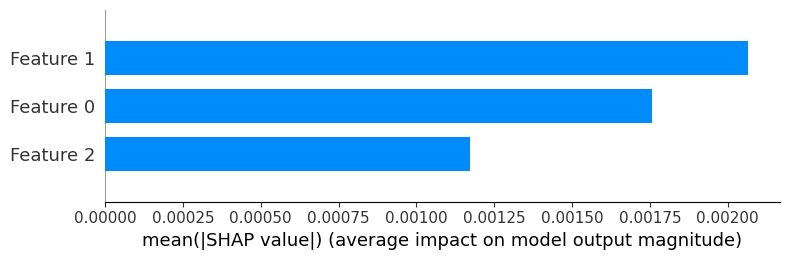

<Figure size 640x480 with 0 Axes>

In [28]:
# Since shap_values might be a list of arrays (for each output of the model), we need to handle this correctly.
# For simplicity, we will consider only the first output.
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Convert SHAP values to 2D array if needed
shap_values = np.array(shap_values)

# Ensure SHAP values and features have the same shape
if len(shap_values.shape) == 3:
    shap_values = shap_values[:, :, 0]

# Print details for validation
print(f"Feature names: {[f'Feature {i}' for i in range(feature_test_subset.shape[1])]}")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Feature test subset shape: {feature_test_subset.shape}")

# Feature names
feature_names = [f"Feature {i}" for i in range(feature_test_subset.shape[1])]

# Summarize the SHAP values with bar plot
shap.summary_plot(shap_values, feature_test_subset, plot_type="bar", feature_names=feature_names)

# Save the plot
plt.savefig('/mnt/data/shap_summary_plot.png')

# Show the plot
plt.show()